In [1]:
import pandas as pd
import pickle
import numpy as np
import re
import scipy.stats as stats
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import RFECV, SelectFromModel
from unidecode import unidecode
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from itertools import combinations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from time import time
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [2]:
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 500)
pd.set_option("display.precision", 4)

# Read in data 

In [3]:
full_df = pd.DataFrame()

In [4]:
# read in alphabetically pickled player data
for i in range(1,27):
    try:
        full_df = full_df.append(pickle.load(open('Data/final_{}.p'.format(i), 'rb')))
        
    except:
        continue

In [5]:
full_df.head(5)

,index,Season,Team,Pos,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,All_star,Player,Salary,AST%,BLK%,BPM,DWS,OWS,PER,STL%,TOV%,TRB%,TS%,USG%,VORP,WS/48
0,0,2016-17,OKC,SG,68.0,6.0,15.5,2.0,5.0,0.393,1.4,3.6,0.381,0.6,1.4,0.426,0.531,0.6,0.7,0.898,0.3,1.0,1.3,0.6,0.5,0.1,0.5,1.7,6.0,0,Álex Abrines,"$5,994,764",5.5,0.6,-1.6,0.9,1.2,10.1,1.7,8.3,4.5,0.560,15.9,0.1,0.096
1,1,2017-18,OKC,SG,75.0,8.0,15.1,1.5,3.9,0.395,1.1,2.9,0.380,0.4,0.9,0.443,0.540,0.5,0.6,0.848,0.3,1.2,1.5,0.4,0.5,0.1,0.3,1.7,4.7,0,Álex Abrines,"$5,725,000",3.4,0.6,-1.5,1.0,1.3,9.0,1.7,7.4,5.6,0.567,12.7,0.1,0.094
2,2,2018-19,OKC,SG,31.0,2.0,19.0,1.8,5.1,0.357,1.3,4.1,0.323,0.5,1.0,0.500,0.487,0.4,0.4,0.923,0.2,1.4,1.5,0.6,0.5,0.2,0.5,1.7,5.3,0,Álex Abrines,"$3,575,183",4.3,0.9,-3.3,0.6,0.1,6.3,1.3,7.9,4.2,0.507,12.2,-0.2,0.053
3,3,2012-13,TOR,PF,29.0,0.0,11.8,1.4,2.6,0.560,0.0,0.1,0.500,1.4,2.5,0.562,0.567,1.1,1.3,0.816,1.0,1.6,2.7,0.4,0.4,0.5,0.6,1.8,4.0,0,Quincy Acy,"$665,000",5.2,3.5,0.1,0.4,0.7,15.9,2.0,15.6,13.4,0.632,14.7,0.2,0.157
4,4,2013-14,TOT,SF,63.0,0.0,13.4,1.0,2.2,0.468,0.1,0.2,0.267,1.0,2.0,0.492,0.482,0.6,0.8,0.660,1.1,2.3,3.4,0.4,0.4,0.4,0.5,1.9,2.7,0,Quincy Acy,"$788,872",4.9,2.5,-1.7,0.9,0.6,10.1,1.4,15.4,14.4,0.520,10.1,0.1,0.086


# Preprocessing

In [6]:
# get rid of $ sign
full_df['Salary'] = full_df['Salary'].apply(lambda x: x if pd.isnull(x) else x.split('$')[1])

In [7]:
# just get the start of the season
full_df['Season'] = full_df['Season'].apply(lambda x: float(x.split('-')[0]))

In [8]:
# get rid of accents on player name
full_df['Player'] = full_df['Player'].apply(lambda x: unidecode(x))

In [9]:
# get rid of ',' and turn into int
full_df['Salary'] = full_df['Salary'].apply(lambda x: ''.join(str(x).split(',')))

In [10]:
full_df['Salary'] = full_df['Salary'].apply(lambda x: x.split('(')[0])

In [11]:
# some players have 2 positions select the first one
full_df['Pos'] = full_df['Pos'].apply(lambda x: x.split(',')[0])

In [12]:
# join PG and SG to 'G
full_df['Pos'] = full_df['Pos'].apply(lambda x: 'G' if 'G' in x else x)

In [13]:
# join SF PF to 'F'
full_df['Pos'] = full_df['Pos'].apply(lambda x: 'F' if 'F' in x else x)

In [14]:
full_df['All_star'] = full_df['All_star'].astype('category')

## Create new columns

In [15]:
# group by season to extract the year each player started their career
full_df = full_df.sort_values(['Player', 'Season'])
first_season = full_df.groupby('Player')['Season'].first()

In [16]:
# create a years played column
full_df['years_played'] = (full_df.set_index('Player')['Season'] - first_season).values

In [17]:
# look at the distribution of years played
# decide where to cut each bin
full_df['years_played'].value_counts(normalize=True).sort_values(ascending=False).cumsum()

0.0     0.1686
1.0     0.3282
2.0     0.4572
3.0     0.5615
4.0     0.6488
5.0     0.7214
6.0     0.7841
7.0     0.8364
8.0     0.8784
9.0     0.9107
10.0    0.9374
11.0    0.9583
12.0    0.9723
13.0    0.9830
14.0    0.9890
15.0    0.9933
16.0    0.9963
17.0    0.9977
18.0    0.9987
19.0    0.9993
20.0    0.9997
21.0    1.0000
Name: years_played, dtype: float64

In [18]:
# cut the players into 4 bins based on years played
full_df['years_bin'] = pd.qcut(full_df['years_played'], 4, labels=['novice', 'rookie', 'seasoned', 'veteran'])

## Handle missing data

In [19]:
# get rid of players who do not have a salary value
full_df = full_df[~full_df['Salary'].str.contains('nan')]

## Deal with players who have 'minimum' as salary

In [20]:
# group by season to take a look at minimum salary for each season
min_salary = full_df.groupby('Season')['Salary'].min().reset_index()

In [21]:
# 2017 min salary 100000
min_salary

,Season,Salary
0,1998.0,1760000
1,1999.0,2267280
2,2000.0,1762320
3,2001.0,1894560
4,2002.0,10067750
5,2003.0,11326219
6,2004.0,1206600
7,2005.0,10993000
8,2006.0,1011720
9,2007.0,10250000


In [22]:
# for players with minimum change the value to 100000
full_df.loc[full_df['Salary']=='Minimum', 'Salary'] = '100000'

In [23]:
full_df['Salary'] = full_df['Salary'].astype(int)

## Looking at correlation

<AxesSubplot:>

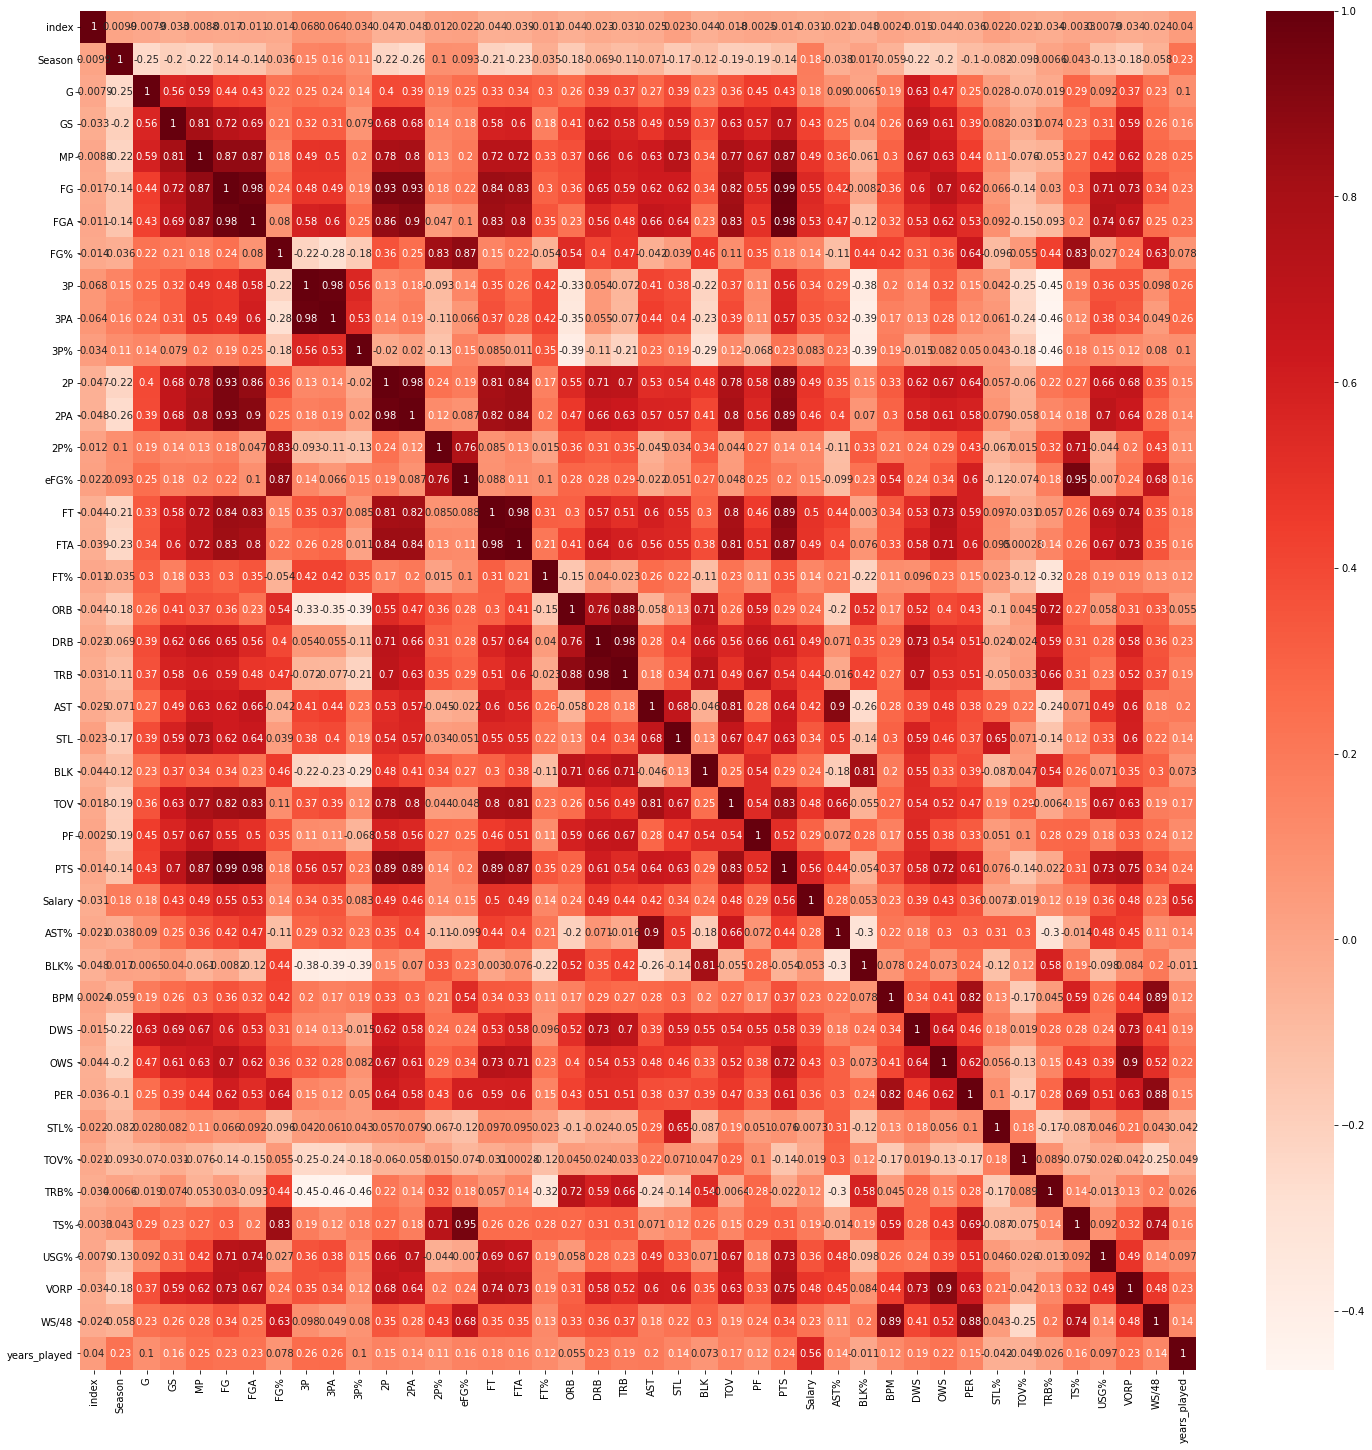

In [24]:
# plot correlation matrix
plt.figure(figsize=(25, 25))
cor = full_df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)


In [25]:
# correlation with output variable
cor_target = abs(cor['Salary'])

# select highly correlated features with the target variable
relevant_features = cor_target[cor_target > 0.5]
relevant_features

FG              0.5531
FGA             0.5348
PTS             0.5632
Salary          1.0000
years_played    0.5616
Name: Salary, dtype: float64

In [26]:
correlated_features = set()
correlation_matrix = full_df.drop('Salary', axis=1).corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [27]:
correlated_features

{'2P',
 '2P%',
 '2PA',
 '3PA',
 'AST%',
 'BLK%',
 'FG',
 'FGA',
 'FT',
 'FTA',
 'MP',
 'PER',
 'PTS',
 'TOV',
 'TRB',
 'TS%',
 'VORP',
 'WS/48',
 'eFG%'}

In [28]:
# look at VIF for each features to decide which to drop
def calc_vif(X):
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [31]:
# drop columns based on inspection of correlation matrix
full_df = full_df.drop(columns=['MP','GS','PTS','FG','FGA','FG%','WS/48', 'TS%', 'eFG%', 'TRB%', 'TRB', 'AST%', 'STL%', 'BLK%', 'TOV%', '2P%', '3P%', 'FT%','USG%', 'BPM'])


## Create dummies for categorical variables

In [35]:
full_df = pd.get_dummies(full_df, columns=['Pos', 'years_bin'])

In [36]:
full_df = full_df.drop(columns=['years_bin_novice', 'Pos_F'])

## Get rid of not needed columns

In [37]:
full_df = full_df.reset_index()
full_df = full_df.drop(columns=['index'])
full_df = full_df.drop(columns=['level_0'])

In [38]:
temp = full_df.copy()

In [39]:
# get rid of players who play way too less games
full_df['G'].value_counts(normalize=True).sort_index().cumsum()
full_df = full_df[full_df['G'] > 21]

## Transform target variable

(array([1395.,  516.,  237.,  223.,  139.,   72.,   52.,   32.,   14.,
           9.]),
 array([1.7092000e+04, 3.8660310e+06, 7.7149700e+06, 1.1563909e+07,
        1.5412848e+07, 1.9261787e+07, 2.3110726e+07, 2.6959665e+07,
        3.0808604e+07, 3.4657543e+07, 3.8506482e+07]),
 <BarContainer object of 10 artists>)

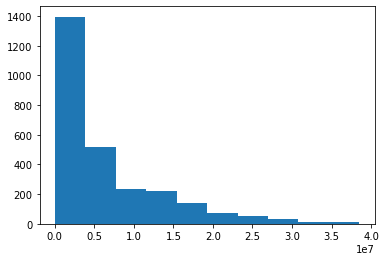

In [40]:
# severe right skew in target variable
plt.hist(full_df['Salary'])

Text(0.5, 1.0, 'Sqrt Transform')

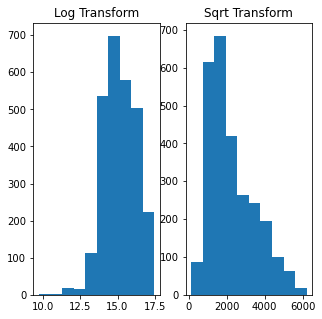

In [41]:
# go with sqrt transform 
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(5, 5))
ax[0].hist(np.log(full_df['Salary']))
ax[0].set_title('Log Transform')
ax[1].hist(np.sqrt(full_df['Salary']))
ax[1].set_title('Sqrt Transform')

# Modeling

## Split data into train/test data set

In [42]:
cut_off = int(len(full_df)*0.7)
train = full_df.sort_values('Season')[:cut_off]
test = full_df.sort_values('Season')[cut_off:]

X_train = train.drop(columns=['Salary'])
y_train = np.sqrt(train['Salary'])
X_cols = X_train.columns

X_test = test.drop(columns=['Salary'])
y_test = np.sqrt(test['Salary'])

In [43]:
X_train = X_train.drop(columns=['Team', 'Player', 'years_played'])
X_test = X_test.drop(columns=['Team', 'Player', 'years_played'])


## Basic Linear Regression

In [44]:
lm = LinearRegression()
lm.fit(X_train, y_train)
lm.score(X_train, y_train)

0.6902952460782977

In [45]:
predicted = lm.predict(X_test)
r_squared = r2_score(y_test, predicted)
mae = mean_absolute_error(predicted, y_test)
rmse = np.sqrt(mean_squared_error(predicted, y_test))
rae = np.mean(abs(predicted - y_test)) / np.mean(abs(y_test - np.mean(y_test)))
rse = np.mean((predicted - y_test)**2) / np.mean((y_test - np.mean(y_test))**2)

In [46]:
summary_df = pd.DataFrame(index = ['R-squared', 'Mean Absolute Error', 'Root Mean Squared Error',
                                   'Relative Absolute Error', 'Relative Squared Error'])
summary_df['Linear Regression, all variables'] = [r_squared, mae, rmse, rae, rse]
summary_df

,"Linear Regression, all variables"
R-squared,0.6327
Mean Absolute Error,646.3053
Root Mean Squared Error,827.7361
Relative Absolute Error,0.5618
Relative Squared Error,0.3673


## Feature selection 

### RFECV Method

In [47]:
# scale the variables
scaler = StandardScaler(with_mean=False)
X_scaled = scaler.fit_transform(X_train)

In [48]:
# apply RFECV with time series based split
# split the data so that test indices are higher than before
tscv = TimeSeriesSplit(n_splits=5)
lm = LinearRegression()
rfecv = RFECV(estimator=lm, step=1, cv=tscv, scoring='neg_mean_squared_error')
rfecv.fit(X_scaled, y_train)


RFECV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
      estimator=LinearRegression(), scoring='neg_mean_squared_error')

In [49]:
print('Optimal number of features: {}'.format(rfecv.n_features_))


Optimal number of features: 25


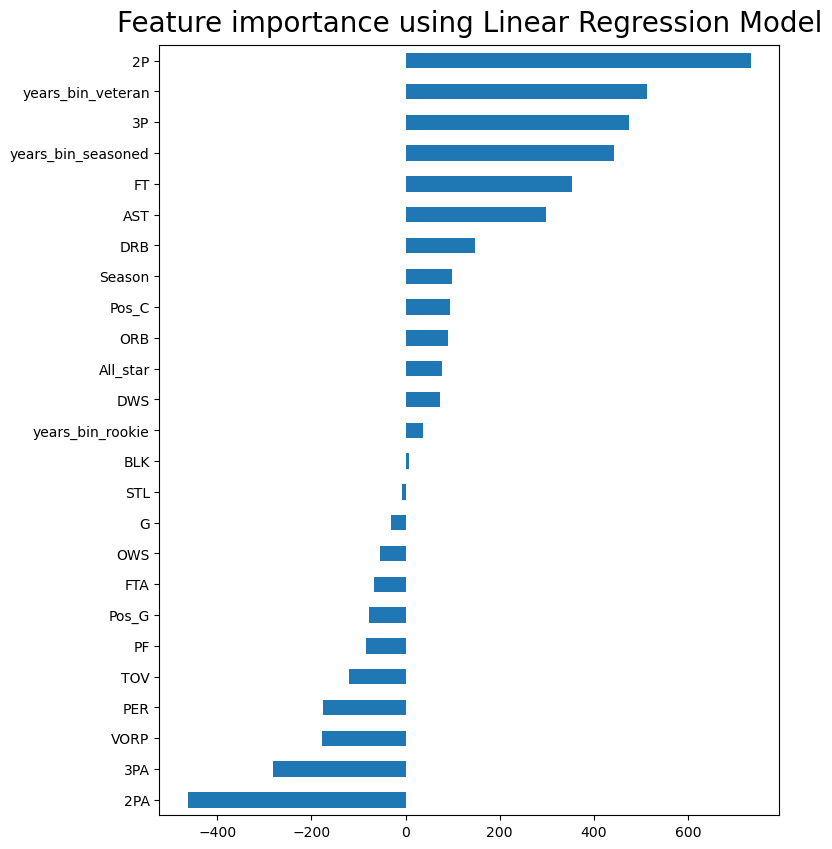

In [50]:
# store the coeffiecients for selected features
rf_coef = pd.Series(rfecv.estimator_.coef_, index=X_train.columns[rfecv.support_]).sort_values()

with plt.style.context('default'):
    plt.rcParams['figure.figsize'] = (8.0, 10.0)
    rf_coef.plot(kind = "barh")
    plt.title("Feature importance using Linear Regression Model", loc='center', pad=10, size=20)
    plt.suptitle('')

## Fit linear regression model using only the selected features 

In [51]:
# run linear regression using only selected features
X_train_subset = X_train[X_train.columns[rfecv.support_]]
lm2 = LinearRegression()
lm2.fit(X_train_subset, y_train)
print(lm2.score(X_train_subset, y_train))


0.6902952460782977


In [52]:
X_test_part = X_test[X_test.columns[rfecv.support_]]
predicted = lm2.predict(X_test_part)
r_squared = r2_score(y_test, predicted)
mae = mean_absolute_error(predicted, y_test)
rmse = np.sqrt(mean_squared_error(predicted, y_test))
rae = np.mean(abs(predicted - y_test)) / np.mean(abs(y_test - np.mean(y_test)))
rse = np.mean((predicted - y_test)**2) / np.mean((y_test - np.mean(y_test))**2)
summary_df['Linear Regression, selected variables'] = [r_squared, mae, rmse, rae, rse]
summary_df

,"Linear Regression, all variables","Linear Regression, selected variables"
R-squared,0.6327,0.6327
Mean Absolute Error,646.3053,646.3053
Root Mean Squared Error,827.7361,827.7361
Relative Absolute Error,0.5618,0.5618
Relative Squared Error,0.3673,0.3673


## Regularization 

### Lasso

In [53]:
# lasso regularization with cross validation
X_train_subset_scale = pd.DataFrame(scaler.fit_transform(X_train_subset), columns=X_train_subset.columns)
reg = LassoCV(cv=tscv)
reg.fit(X_train_subset_scale, y_train)
print("Best score using built-in LassoCV: %f" %reg.score(X_train_subset_scale,y_train))
coef = pd.Series(reg.coef_, index=X_train_subset_scale.columns)

Best score using built-in LassoCV: 0.689833


In [54]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 24 variables and eliminated the other 1 variables


In [55]:
X_test_part = X_test[X_test.columns[rfecv.support_]]
predicted = reg.predict(scaler.transform(X_test_part))

In [56]:
r_squared = r2_score(y_test, predicted)
mae = mean_absolute_error(predicted, y_test)
rmse = np.sqrt(mean_squared_error(predicted, y_test))
rae = np.mean(abs(predicted - y_test)) / np.mean(abs(y_test - np.mean(y_test)))
rse = np.mean((predicted - y_test)**2) / np.mean((y_test - np.mean(y_test))**2)
summary_df['Linear Regression/Lasso'] = [r_squared, mae, rmse, rae, rse]
summary_df

,"Linear Regression, all variables","Linear Regression, selected variables",Linear Regression/Lasso
R-squared,0.6327,0.6327,0.6289
Mean Absolute Error,646.3053,646.3053,650.1280
Root Mean Squared Error,827.7361,827.7361,832.0165
Relative Absolute Error,0.5618,0.5618,0.5651
Relative Squared Error,0.3673,0.3673,0.3711


#### Ridge

In [57]:
# ridge regularization with cross validation
X_train_subset_scale = pd.DataFrame(scaler.fit_transform(X_train_subset), columns=X_train_subset.columns)
reg = RidgeCV(cv=tscv)
reg.fit(X_train_subset_scale, y_train)
print("Best score using built-in LassoCV: %f" %reg.score(X_train_subset_scale,y_train))
coef = pd.Series(reg.coef_, index=X_train_subset_scale.columns)

Best score using built-in LassoCV: 0.689086


In [58]:
X_test_part = X_test[X_test.columns[rfecv.support_]]
predicted = reg.predict(scaler.transform(X_test_part))
r_squared = r2_score(y_test, predicted)
mae = mean_absolute_error(predicted, y_test)
rmse = np.sqrt(mean_squared_error(predicted, y_test))
rae = np.mean(abs(predicted - y_test)) / np.mean(abs(y_test - np.mean(y_test)))
rse = np.mean((predicted - y_test)**2) / np.mean((y_test - np.mean(y_test))**2)
summary_df['Linear Regression/Ridge'] = [r_squared, mae, rmse, rae, rse]
summary_df

,"Linear Regression, all variables","Linear Regression, selected variables",Linear Regression/Lasso,Linear Regression/Ridge
R-squared,0.6327,0.6327,0.6289,0.6257
Mean Absolute Error,646.3053,646.3053,650.1280,653.6099
Root Mean Squared Error,827.7361,827.7361,832.0165,835.5888
Relative Absolute Error,0.5618,0.5618,0.5651,0.5682
Relative Squared Error,0.3673,0.3673,0.3711,0.3743


## Add interaction terms

In [59]:
# Run linear regression with interaction terms
p = PolynomialFeatures(degree=2, interaction_only=True)
lm = LinearRegression()
X_train_poly = pd.DataFrame(p.fit_transform(X_train), columns=p.get_feature_names(X_train.columns))
lm.fit(X_train_poly, y_train)
lm.score(X_train_poly, y_train)

0.7977030747420346

In [60]:
predicted = lm.predict(p.transform(X_test))
lm.score(p.transform(X_test), y_test)
r_squared = r2_score(y_test, predicted)
mae = mean_absolute_error(predicted, y_test)
rmse = np.sqrt(mean_squared_error(predicted, y_test))
rae = np.mean(abs(predicted - y_test)) / np.mean(abs(y_test - np.mean(y_test)))
rse = np.mean((predicted - y_test)**2) / np.mean((y_test - np.mean(y_test))**2)
summary_df['Linear Regression, interaction'] = [r_squared, mae, rmse, rae, rse]
summary_df

,"Linear Regression, all variables","Linear Regression, selected variables",Linear Regression/Lasso,Linear Regression/Ridge,"Linear Regression, interaction"
R-squared,0.6327,0.6327,0.6289,0.6257,0.6569
Mean Absolute Error,646.3053,646.3053,650.1280,653.6099,603.1483
Root Mean Squared Error,827.7361,827.7361,832.0165,835.5888,800.0064
Relative Absolute Error,0.5618,0.5618,0.5651,0.5682,0.5243
Relative Squared Error,0.3673,0.3673,0.3711,0.3743,0.3431


## Regularization

### Lasso

In [61]:
X_train_subset_scale = pd.DataFrame(scaler.fit_transform(X_train_poly), columns=X_train_poly.columns)
reg = LassoCV(cv=tscv)
reg.fit(X_train_subset_scale, y_train)
#print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in RidgeCV: %f" %reg.score(X_train_subset_scale,y_train))
coef = pd.Series(reg.coef_, index=X_train_subset_scale.columns)

Best score using built-in RidgeCV: 0.748652


In [62]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 110 variables and eliminated the other 216 variables


In [63]:
predicted = reg.predict(scaler.transform(p.transform(X_test)))
r_squared = r2_score(y_test, predicted)
mae = mean_absolute_error(predicted, y_test)
rmse = np.sqrt(mean_squared_error(predicted, y_test))
rae = np.mean(abs(predicted - y_test)) / np.mean(abs(y_test - np.mean(y_test)))
rse = np.mean((predicted - y_test)**2) / np.mean((y_test - np.mean(y_test))**2)
summary_df['Linear Regression, interaction/Lasso'] = [r_squared, mae, rmse, rae, rse]
summary_df

,"Linear Regression, all variables","Linear Regression, selected variables",Linear Regression/Lasso,Linear Regression/Ridge,"Linear Regression, interaction","Linear Regression, interaction/Lasso"
R-squared,0.6327,0.6327,0.6289,0.6257,0.6569,0.6576
Mean Absolute Error,646.3053,646.3053,650.1280,653.6099,603.1483,612.2595
Root Mean Squared Error,827.7361,827.7361,832.0165,835.5888,800.0064,799.1595
Relative Absolute Error,0.5618,0.5618,0.5651,0.5682,0.5243,0.5322
Relative Squared Error,0.3673,0.3673,0.3711,0.3743,0.3431,0.3424


In [64]:
# just look at interaction terms
coef = coef[coef.index[27:]].sort_values(ascending=False)
coef = coef.sort_values()

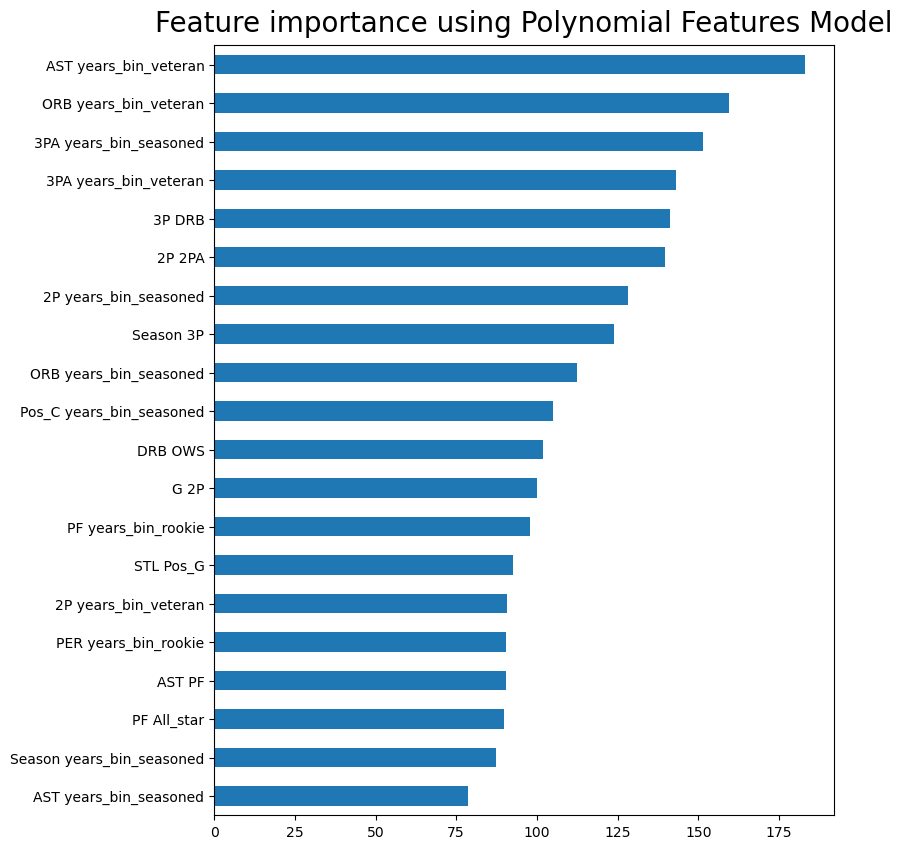

In [65]:
# feature importance of interaction terms
with plt.style.context('default'):
    plt.rcParams['figure.figsize'] = (8.0, 10.0)
    coef.tail(20).plot(kind = "barh")
    plt.title("Feature importance using Polynomial Features Model", loc='center', pad=10, size=20)

### Ridge 

In [66]:
X_train_subset_scale = pd.DataFrame(scaler.fit_transform(X_train_poly), columns=X_train_poly.columns)
reg = RidgeCV(cv=tscv)
reg.fit(X_train_subset_scale, y_train)
#print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in RidgeCV: %f" %reg.score(X_train_subset_scale,y_train))
coef = pd.Series(reg.coef_, index=X_train_subset_scale.columns)

Best score using built-in RidgeCV: 0.767529


In [67]:
predicted = reg.predict(scaler.transform(p.transform(X_test)))
r_squared = r2_score(y_test, predicted)
mae = mean_absolute_error(predicted, y_test)
rmse = np.sqrt(mean_squared_error(predicted, y_test))
rae = np.mean(abs(predicted - y_test)) / np.mean(abs(y_test - np.mean(y_test)))
rse = np.mean((predicted - y_test)**2) / np.mean((y_test - np.mean(y_test))**2)
summary_df['Linear Regression, interaction/Ridge'] = [r_squared, mae, rmse, rae, rse]
summary_df

,"Linear Regression, all variables","Linear Regression, selected variables",Linear Regression/Lasso,Linear Regression/Ridge,"Linear Regression, interaction","Linear Regression, interaction/Lasso","Linear Regression, interaction/Ridge"
R-squared,0.6327,0.6327,0.6289,0.6257,0.6569,0.6576,0.6655
Mean Absolute Error,646.3053,646.3053,650.1280,653.6099,603.1483,612.2595,601.9400
Root Mean Squared Error,827.7361,827.7361,832.0165,835.5888,800.0064,799.1595,789.8165
Relative Absolute Error,0.5618,0.5618,0.5651,0.5682,0.5243,0.5322,0.5233
Relative Squared Error,0.3673,0.3673,0.3711,0.3743,0.3431,0.3424,0.3345


# Assumptions Check

In [68]:
y_pred_test = reg.predict(scaler.transform(p.transform(X_test)))


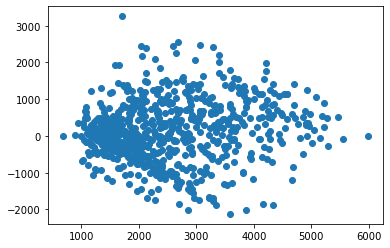

In [69]:
lasso_resid = y_test-y_pred_test
plt.scatter(y_pred_test, lasso_resid)

[]

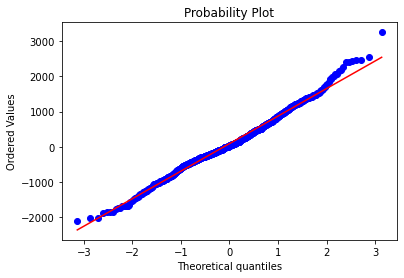

In [70]:
stats.probplot(lasso_resid, dist="norm", plot=plt)
plt.plot()


# Fit the model on the entire data

In [71]:
# prepare dataframe to fit model
temp_df = temp.drop(columns=['Salary', 'Team', 'Player', 'years_played'])
temp_df = pd.DataFrame(p.transform(temp_df), columns=p.get_feature_names(temp_df.columns))


In [72]:
# fit model on the full data 
temp_df['predicted_salary'] = reg.predict(scaler.transform(temp_df))
temp_df['Salary'] = full_df['Salary']
temp_df['predicted_salary'] = temp_df['predicted_salary']**2
temp_df['resid'] = temp_df['predicted_salary']-temp_df['Salary']
temp_df['Player'] = full_df['Player']

# take a look at the overpaid players (residual high)
temp_df[['Season', 'Player', 'Salary', 'predicted_salary', 'resid']].sort_values(by=['resid', 'Season'], ascending=False).head()

,Season,Player,Salary,predicted_salary,resid
2084,2019.0,Montrezl Harrell,6000000.0,1.8746e+07,1.2746e+07
602,2018.0,DeMarcus Cousins,5337000.0,1.7280e+07,1.1943e+07
287,2018.0,Brook Lopez,3382000.0,1.4923e+07,1.1541e+07
2796,2017.0,Tyreke Evans,3290000.0,1.4178e+07,1.0888e+07
357,2019.0,Carmelo Anthony,2159029.0,1.2902e+07,1.0743e+07


In [73]:
# take a look at lebron's predicted vs actual
james = temp_df[temp_df['Player']=='LeBron James'][['Season', 'Salary', 'predicted_salary', 'resid']]

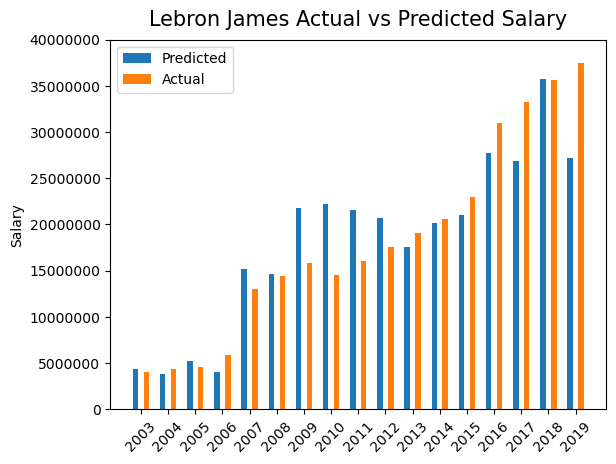

In [79]:
with plt.style.context('default'):

    width=0.2
    ypos=np.arange(len(james))
    plt.bar(ypos-0.2, james['predicted_salary'] , width, label='Predicted')
    plt.bar(ypos+0.2, james['Salary'], width, label='Actual')
    plt.title("Lebron James Actual vs Predicted Salary", loc='center', pad=10, size=15)
    plt.xticks(ypos,james['Season'].astype(int), rotation='45')
    plt.ylabel('Salary')
    plt.ylim(0, 40000000)
    plt.ticklabel_format(style='plain', axis='y')

    plt.legend()

In [80]:
# take a look at otto's predicted vs actual
otto = temp_df[temp_df['Player']=='Otto Porter'][['Season', 'Salary', 'predicted_salary', 'resid']]

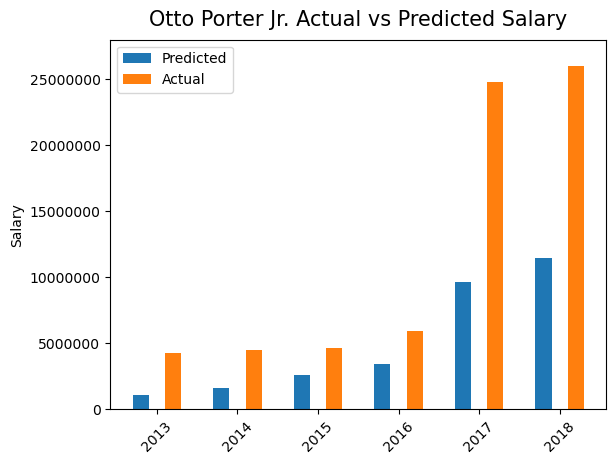

In [81]:
with plt.style.context('default'):

    ypos=np.arange(len(otto))
    plt.bar(ypos-0.2, otto['predicted_salary'] , width, label='Predicted')
    plt.bar(ypos+0.2, otto['Salary'], width, label='Actual')
    plt.title("Otto Porter Jr. Actual vs Predicted Salary", loc='center', pad=10, size=15)
    plt.xticks(ypos,otto['Season'].astype(int), rotation='45')
    plt.ylabel('Salary')
    plt.ylim(0, 28000000)
    plt.ticklabel_format(style='plain', axis='y')

    plt.legend(loc='upper left')

In [82]:
# take a look at spencer's predicted vs actual
spence = temp_df[temp_df['Player']=='Spencer Dinwiddie'][['Season', 'Salary', 'predicted_salary', 'resid']]

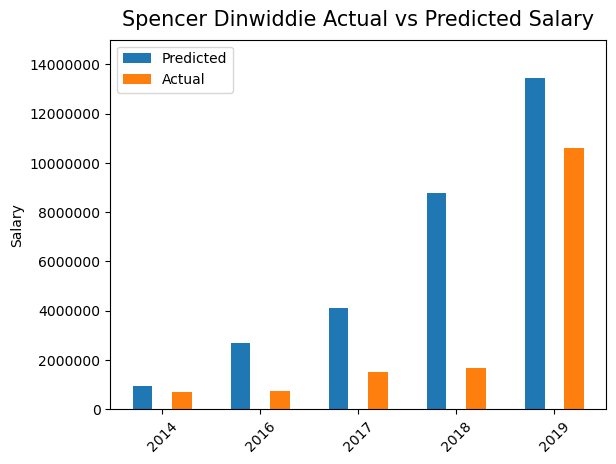

In [83]:
with plt.style.context('default'):

    ypos=np.arange(len(spence))
    plt.bar(ypos-0.2, spence['predicted_salary'] , width, label='Predicted')
    plt.bar(ypos+0.2, spence['Salary'], width, label='Actual')
    plt.title("Spencer Dinwiddie Actual vs Predicted Salary", loc='center', pad=10, size=15)
    plt.xticks(ypos,spence['Season'].astype(int), rotation='45')
    plt.ylabel('Salary')
    plt.ylim(0, 15000000)
    plt.ticklabel_format(style='plain', axis='y')

    plt.legend(loc='upper left')